In [11]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col

In [12]:
sp = SparkSession.builder.appName("Checker").getOrCreate()
sp

In [13]:
trans = sp.read.option("inferSchema", True).parquet("../data/curated/transactions")
trans.show(3)

+-------+------------+------------+--------------+-----------+
|user_id|merchant_abn|dollar_value|order_datetime|   order_id|
+-------+------------+------------+--------------+-----------+
|  14935| 79417999332|      136.07|    2021-11-26|68719476736|
|      1| 46451548968|       72.62|    2021-11-26|68719476737|
|  14936| 89518629617|        3.08|    2021-11-26|68719476738|
+-------+------------+------------+--------------+-----------+
only showing top 3 rows



In [14]:
trans.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: float (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- order_id: long (nullable = true)



### Checking the customers that exist in fraud data

In [16]:
model_data = sp.read.option("inferSchema", True).parquet("../data/processed/model_data")
model_data.show(2)

+-------+------------+------------+--------------+
|user_id|merchant_abn|dollar_value|order_datetime|
+-------+------------+------------+--------------+
|  14936| 89518629617|        3.08|    2021-11-26|
|  14936| 31101120643|       25.23|    2021-11-26|
+-------+------------+------------+--------------+
only showing top 2 rows



In [17]:
cfraud = sp.read.option("inferSchema", True).parquet("../data/curated/customer_fraud")
cfraud.show()

+-------+-------------------+-----------------+
|user_id|     order_datetime|fraud_probability|
+-------+-------------------+-----------------+
|   6228|2021-12-19 00:00:00|         97.62981|
|  21419|2021-12-10 00:00:00|         99.24738|
|   5606|2021-10-17 00:00:00|         84.05825|
|   3101|2021-04-16 23:00:00|         91.42192|
|  22239|2021-10-19 00:00:00|         94.70342|
|  16556|2022-02-20 00:00:00|         89.65663|
|  10278|2021-09-27 23:00:00|         83.59137|
|  15790|2021-12-30 00:00:00|         71.77066|
|   5233|2021-08-28 23:00:00|         85.87123|
|    230|2021-08-27 23:00:00|         86.28329|
|  13601|2021-12-26 00:00:00|         83.13696|
|   6383|2021-09-14 23:00:00|         66.26765|
|   3513|2022-02-27 00:00:00|        75.169815|
|  18658|2021-10-19 00:00:00|         82.98609|
|   5965|2021-11-14 00:00:00|         69.37164|
|  18714|2021-11-14 00:00:00|         83.78814|
|  22957|2022-02-12 00:00:00|         82.79066|
|  20118|2021-09-04 23:00:00|          8

In [19]:
from pyspark.sql.types import DateType

cfraud = cfraud.withColumn("order_datetime", col("order_datetime").cast(DateType()))
cfraud.printSchema()
cfraud.show(2)

root
 |-- user_id: integer (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- fraud_probability: float (nullable = true)

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19|         97.62981|
|  21419|    2021-12-10|         99.24738|
+-------+--------------+-----------------+
only showing top 2 rows



In [26]:
legit_fraud_custs = cfraud.join(model_data.select("user_id").distinct(), on="user_id")
legit_fraud_custs.show(2)

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|     26|    2021-11-19|        10.604536|
|     29|    2021-10-31|          8.44397|
+-------+--------------+-----------------+
only showing top 2 rows



In [27]:
legit_fraud_custs.count()

11605

In [28]:
cfraud_pd = cfraud.toPandas()
legit_fraud_pd = legit_fraud_custs.toPandas()

legit_fraud_pd.head()

,user_id,order_datetime,fraud_probability
0,26,2021-11-19,10.604536
1,29,2021-10-31,8.443970
2,29,2021-11-25,15.492410
3,15057,2022-01-11,36.562668
4,15237,2022-01-09,8.632889


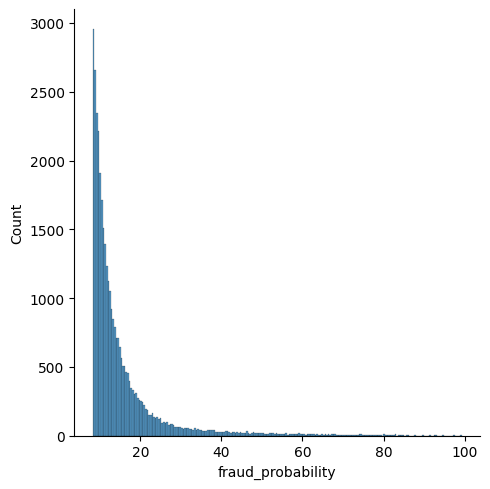

In [30]:
import seaborn as sns

sns.displot(cfraud_pd["fraud_probability"])

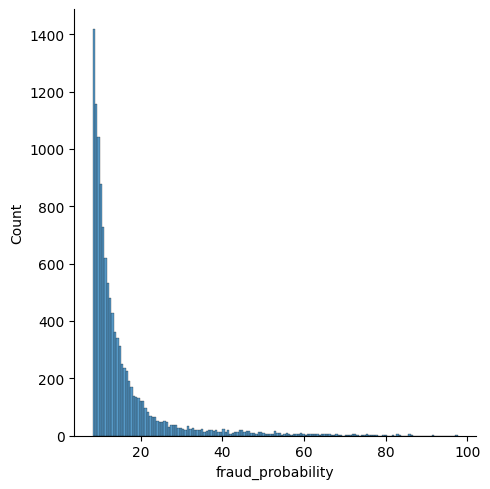

In [31]:
sns.displot(legit_fraud_pd["fraud_probability"])

The distributions are very similar and so that should not be a problem

### Verify that customers do not have more information

In [34]:
consumer_tbl = sp.read.option("inferSchema", True).option("header", True).option("delimiter", "|").csv("../data/tables/tbl_consumer.csv")
consumer_tbl.show(2)
consumer_tbl.printSchema()

+----------------+--------------------+-----+--------+------+-----------+
|            name|             address|state|postcode|gender|consumer_id|
+----------------+--------------------+-----+--------+------+-----------+
|Yolanda Williams|413 Haney Gardens...|   WA|    6935|Female|    1195503|
|      Mary Smith|     3764 Amber Oval|  NSW|    2782|Female|     179208|
+----------------+--------------------+-----+--------+------+-----------+
only showing top 2 rows

root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- consumer_id: integer (nullable = true)



In [49]:
consumer_tbl.select("consumer_id").distinct().count()

499999

In [50]:
trans.select("user_id").distinct().count()

24081

In [35]:
lookup = sp.read.option("inferSchema", True).parquet("../data/tables/consumer_user_details.parquet")
lookup.show(2)

+-------+-----------+
|user_id|consumer_id|
+-------+-----------+
|      1|    1195503|
|      2|     179208|
+-------+-----------+
only showing top 2 rows



In [37]:
consumer_tbl_joined = consumer_tbl.join(lookup, on="consumer_id")
consumer_tbl_joined.show(2)

+-----------+----------------+--------------------+-----+--------+------+-------+
|consumer_id|            name|             address|state|postcode|gender|user_id|
+-----------+----------------+--------------------+-----+--------+------+-------+
|    1195503|Yolanda Williams|413 Haney Gardens...|   WA|    6935|Female|      1|
|     179208|      Mary Smith|     3764 Amber Oval|  NSW|    2782|Female|      2|
+-----------+----------------+--------------------+-----+--------+------+-------+
only showing top 2 rows



In [39]:
final = consumer_tbl_joined.join(trans.select("user_id").distinct(), on="user_id")
final.show()

+-------+-----------+-----------------+--------------------+-----+--------+-----------+
|user_id|consumer_id|             name|             address|state|postcode|     gender|
+-------+-----------+-----------------+--------------------+-----+--------+-----------+
|      1|    1195503| Yolanda Williams|413 Haney Gardens...|   WA|    6935|     Female|
|      2|     179208|       Mary Smith|     3764 Amber Oval|  NSW|    2782|     Female|
|      3|    1194530|    Jill Jones MD|  40693 Henry Greens|   NT|     862|     Female|
|      4|     154128|  Lindsay Jimenez|00653 Davenport C...|  NSW|    2780|     Female|
|      5|     712975|Rebecca Blanchard|9271 Michael Mano...|   WA|    6355|     Female|
|      6|     407340|    Karen Chapman|2706 Stewart Oval...|  NSW|    2033|     Female|
|      7|     511685|     Andrea Jones|   122 Brandon Cliff|  QLD|    4606|     Female|
|      8|     448088| Stephen Williams|6804 Wright Crest...|   WA|    6056|       Male|
|      9|     650435|  Stephanie

In [40]:
final.count()
# 24081 customers are in the database

24081

There are 24k unique customers that have addresses. Next to check - how many transactions do they make

In [46]:
trans.select("user_id").distinct().count()

24081

In [43]:
model_trans = trans.join(final.select("user_id").distinct(), on="user_id")
model_trans.show(2)

+-------+------------+------------+--------------+-----------+
|user_id|merchant_abn|dollar_value|order_datetime|   order_id|
+-------+------------+------------+--------------+-----------+
|      7| 71041015148|       226.7|    2021-11-26|68719476757|
|      7| 14492521225|       28.69|    2021-11-26|68719476759|
+-------+------------+------------+--------------+-----------+
only showing top 2 rows



In [44]:
model_trans.count()

14195505

In [45]:
model_trans.dropna().count()

14195505

In [54]:
from functools import reduce

from pyspark.sql import SparkSession, DataFrame

def read_tables(sp: SparkSession, file: str, ftype = "p", sample=False):
    """
    Helper function to read data from the desginated folder

    sp : Current SparkSession
    file : Type of data/Name of file name to be read
            (if file is "transactions" no ftype needed)
    ftype : File type (Parquet(p) or CSV(c))

    returns DataFrame read
    """
    # Root directory
    dir = "../data/tables/"
    
    # Transaction folders
    if file == "transactions":
        # Read all transactions together
        groups = [
            "transactions_20210228_20210827_snapshot/",
            "transactions_20210828_20220227_snapshot/",
            "transactions_20220228_20220828_snapshot/"
            ]

        # Read the different transaction folders
        final_list = []
        for g in groups:
            final_list.append(sp.read.option("inferSchema", True).parquet(dir + g))

        if not sample:
            return reduce(DataFrame.unionAll, final_list)
        return reduce(DataFrame.unionAll, final_list).sample(0.01)

    # Special file
    elif file == "tbl_consumer":
        return sp.read.option("inferSchema", True).option("header", True).option("delimiter", "|").csv("../data/tables/tbl_consumer.csv")

    # Parquet files
    if ftype == "p":
        return sp.read.option("inferSchema", True).parquet(dir + file + ".parquet")
    elif ftype == "c":
        return sp.read.option("inferSchema", True).option("header", True).csv(dir + file + ".csv")


In [55]:
pre_trans = read_tables(sp, "transactions")
pre_trans.show(2)

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 2 rows



In [56]:
pre_trans.select("user_id").distinct().count()

24081